#Data Loading and Spliting

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split
import time
import csv
from sklearn.dummy import DummyClassifier
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Import Datasets
!unzip -q '/content/drive/My Drive/APS360 Project/Breed_Group_Dataset.zip'
!unzip -q '/content/drive/My Drive/APS360 Project/Test Set.zip'

In [4]:
%%time
# Location of Datasets on Google Drive
train_path = '/content/Breed_Group_Dataset/'
test_path = '/content/Test Set/'

# Transform Settings
train_transform = transforms.Compose([transforms.CenterCrop((360,360)),
                                transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomRotation(15),
                                transforms.RandomAdjustSharpness(0.5, p=0.1),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
test_transform = transforms.Compose([transforms.CenterCrop((360,360)),
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
 
# Create full dataset
full_dataset = torchvision.datasets.ImageFolder(train_path, transform=train_transform)
train_dataset = torchvision.datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(train_path, transform=test_transform)
test_dataset = torchvision.datasets.ImageFolder(test_path, transform=test_transform)


# Generate a function to obtain a subset of images
def get_subset(indices, start, end):
    return indices[start : start + end]

# Define the split ratio for training and validation
train_percentage, val_percentage = 0.8, 0.2
train_count = int(len(full_dataset) * train_percentage)
val_count = int(len(full_dataset) * val_percentage)
test_count = int(len(test_dataset))

# Obtain indices for each set's dataloader (won't be used for test)
indices = torch.randperm(len(full_dataset))
train_indices = get_subset(indices, 0, train_count)
val_indices = get_subset(indices, train_count, val_count)

CPU times: user 214 ms, sys: 24.2 ms, total: 238 ms
Wall time: 265 ms


#Load Model

In [5]:
#Load ResNet34
use_cuda = True

resnet34 = models.resnet34(pretrained=True)
num_ftrs = resnet34.fc.in_features

#Freeze convolutional network parameters
for param in resnet34.parameters():
    param.requires_grad = False

# Here the size of each output sample is set to 7 for our number of classes.
resnet34.name = 'ResNet34'
resnet34.fc = nn.Sequential(
            nn.Linear(num_ftrs , 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 7)
        )

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [7]:
def get_accuracy(model, data_loader):
  with torch.no_grad():
    correct = 0
    total = 0
    for imgs, labels in data_loader:
    
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
  return correct / total

In [8]:
#Load best model state

use_cuda = True

best_model = resnet34
#If testing new run (check epoch choice)
#best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("ResNet34",128, 0.01, 8)
#Load best model state
best_model_path = "/content/drive/MyDrive/APS360 Project/model_{0}_bs{1}_lr{2}_epoch{3}".format("ResNet34",128, 0.01, 8)
state = torch.load(best_model_path)
best_model.load_state_dict(state)
if use_cuda and torch.cuda.is_available():
    best_model.cuda()

best_model.train(False)

with torch.no_grad():
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, sampler=SubsetRandomSampler(val_indices))
  val_accuracy = get_accuracy(best_model, val_loader)
  print("Validation accuracy:", val_accuracy)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)
  test_accuracy = get_accuracy(best_model, test_loader)
  print("Test accuracy:", test_accuracy)

Validation accuracy: 0.8644615767222084
Test accuracy: 0.88


#Confusion Matrix

In [9]:
#Function to get prediction values for model and data loader

def get_all_preds(model, loader):
    model.train(False)
    all_preds = torch.tensor([]).cuda()
    all_labels = torch.tensor([]).cuda()
    for batch in loader:
        images, labels = batch
        images = images.cuda()
        labels = labels.cuda()

        preds = model(images)
        all_preds = torch.cat((all_preds, preds),dim=0)
        all_labels = torch.cat((all_labels, labels),dim=0)
        
    return all_preds, all_labels

In [11]:
#Function to plot confusion matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
#Get validation set predictions

with torch.no_grad():
  val_preds, val_labels = get_all_preds(best_model, val_loader)

print(val_preds.shape)
print(val_labels.shape)
print(val_preds.argmax(dim=1).shape)

torch.Size([4021, 7])
torch.Size([4021])
torch.Size([4021])


In [12]:
#Get test set predictions

with torch.no_grad():
  test_preds, test_labels = get_all_preds(best_model, test_loader)

print(test_preds.shape)
print(test_labels.shape)
print(test_preds.argmax(dim=1).shape)

torch.Size([350, 7])
torch.Size([350])
torch.Size([350])


Confusion matrix, without normalization
[[396  14   5   8   7   7  14]
 [ 10 590   3  22  11  14  19]
 [  9   3 252   6  12  45  29]
 [  4  19   6 511   5   9   8]
 [  8  10  10  12 608  33   4]
 [  5  15  19   5  21 569   6]
 [ 24  25   4  13  29  13 550]]


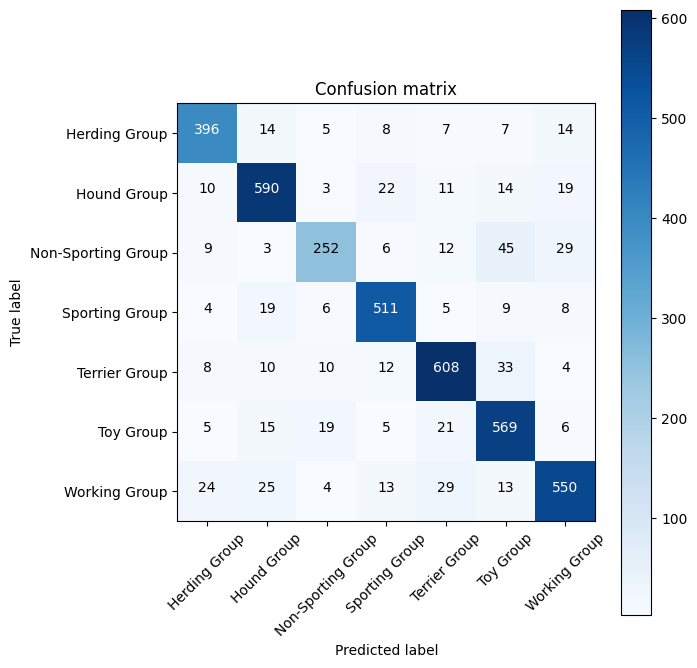

In [17]:
#Plot validation confusion matrix

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

cm_val = confusion_matrix(val_labels.cpu(),val_preds.argmax(dim=1).cpu())
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm_val, val_dataset.classes)

Confusion matrix, without normalization
[[43  0  2  0  3  0  2]
 [ 0 44  0  3  0  2  1]
 [ 3  0 42  0  0  4  1]
 [ 0  1  0 48  0  0  1]
 [ 1  1  1  1 46  0  0]
 [ 0  0  5  1  1 43  0]
 [ 0  1  1  3  2  1 42]]


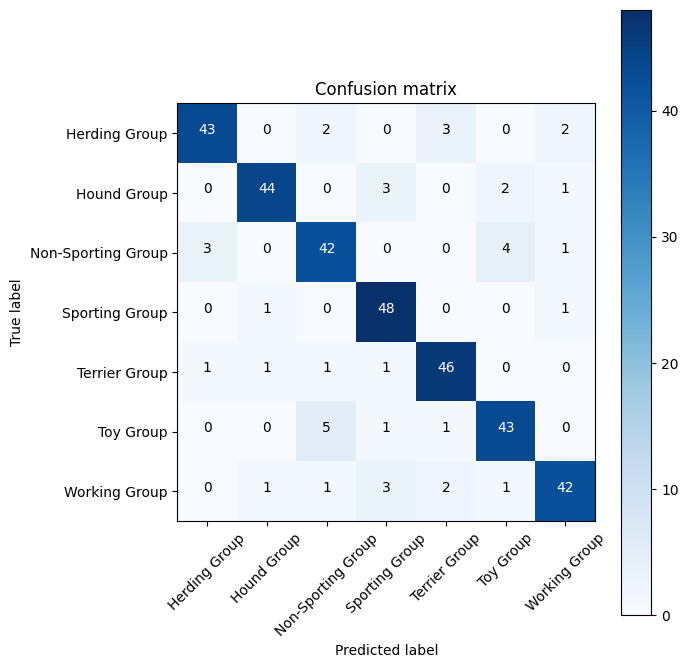

In [18]:
#Plot test confusion matrix

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

cm_test = confusion_matrix(test_labels.cpu(),test_preds.argmax(dim=1).cpu())
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm_test, test_dataset.classes)

#Probability Distribution

Distribution:  [0.0078125 0.0234375 0.0296875 0.0078125 0.0328125 0.8890625 0.009375 ]


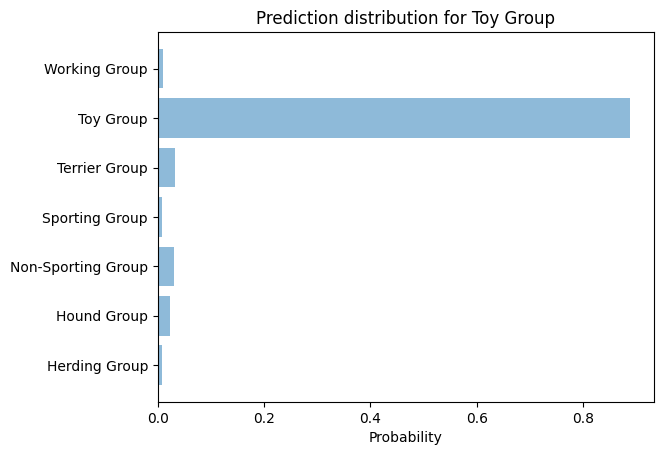

In [22]:
#Toy Group

classes = full_dataset.classes

toy_preds = np.array(cm_val[5][:])
toy_preds_norm = (toy_preds/np.sum(toy_preds))
print("Distribution: ",toy_preds_norm)
np.sum(toy_preds_norm)

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = classes
y_pos = np.arange(len(classes))
performance = toy_preds_norm

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Probability')
plt.title('Prediction distribution for Toy Group')

plt.show()

Distribution:  [0.0252809  0.00842697 0.70786517 0.01685393 0.03370787 0.12640449
 0.08146067]


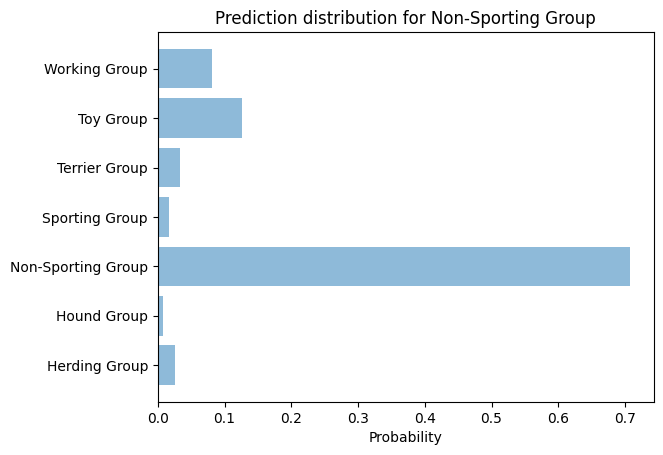

In [27]:
#Non-Sporting Group

classes = full_dataset.classes

nonsp_preds = np.array(cm_val[2][:])
nonsp_preds_norm = (nonsp_preds/np.sum(nonsp_preds))
print("Distribution: ",nonsp_preds_norm)
np.sum(nonsp_preds_norm)

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = classes
y_pos = np.arange(len(classes))
performance = nonsp_preds_norm

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Probability')
plt.title('Prediction distribution for Non-Sporting Group')

plt.show()

Distribution:  [0.01167883 0.01459854 0.01459854 0.01751825 0.88759124 0.04817518
 0.00583942]


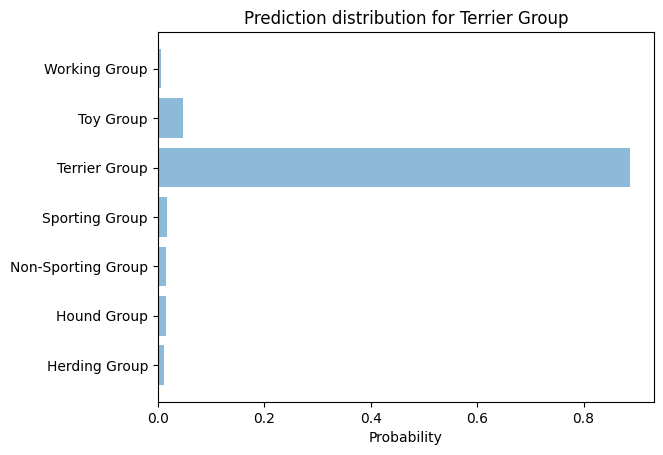

In [28]:
#Terrier Group

classes = full_dataset.classes

terrier_preds = np.array(cm_val[4][:])
terrier_preds_norm = (terrier_preds/np.sum(terrier_preds))
print("Distribution: ",terrier_preds_norm)
np.sum(terrier_preds_norm)

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = classes
y_pos = np.arange(len(classes))
performance = terrier_preds_norm

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Probability')
plt.title('Prediction distribution for Terrier Group')

plt.show()

#Feature Visualization

In [30]:
!unzip -q '/content/drive/My Drive/APS360 Project/Sample Images for Qualitative Results.zip'

In [31]:
# Location of Sample Images on Google Drive
image_path = '/content/Sample Images for Qualitative Results/'

# Transform Settings
sample_transform = transforms.Compose([transforms.CenterCrop((360,360)),
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ]) 
# Create sample dataset
sample_dataset = torchvision.datasets.ImageFolder(image_path, transform=sample_transform)

In [33]:
#Load base ResNet34
resnet34_test = models.resnet34(pretrained=True)
sample_loader = torch.utils.data.DataLoader(sample_dataset, batch_size=1)

In [34]:
class Partial_Resnet(nn.Module):
    def __init__(self, resnetModel, final_layer_name):
        super().__init__()

        #Extract all layers from the passed resnet model up to and including
        #the specified final layer.
        self.layers = []
        for layer_name, layer in resnetModel.named_children() :
            self.layers.append(layer)
            if (layer_name == final_layer_name) :
                break


        #The overall network is the sequential application of the
        #selected layers from resnet. 
        self.overall_net = nn.Sequential(*self.layers)
        
        
    def forward(self,x):
        x = self.overall_net(x)
        return x

intermediateResnet = Partial_Resnet(resnet34_test, "maxpool")

In [50]:
for imgs, labels in iter(sample_loader): 
      plt.show()
      plt.imshow(imgs[0].permute(1, 2, 0))

      intermediateResnet.train(False)

      out = intermediateResnet(imgs)
      print(out.shape)

      sampleFeatureMap = out.detach().numpy()
      print(sampleFeatureMap.shape)

      plt.figure(figsize=(15,15))
      for i in range(64):
        plt.subplot(8, 8, i+1)
        plt.imshow(sampleFeatureMap[0, i])



Output hidden; open in https://colab.research.google.com to view.